In [1]:
import os
import pickle
import numpy as np
import networkx as nx
import statsmodels.api as sm
import matplotlib.pyplot as plt
from seaborn import color_palette
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# some useful paths
RETURN_PATH = './intermediate/daily_return'
INFO_PATH = './intermediate/stock_info'
FACTORS_PATH = './intermediate/factors'
OUTPUT_PATH = './output'
OUTPUT_FIGURE_PATH = OUTPUT_PATH + '/figure'
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)
if not os.path.exists(OUTPUT_FIGURE_PATH):
    os.mkdir(OUTPUT_FIGURE_PATH)

In [3]:
# load data
y = np.loadtxt(RETURN_PATH + '/all.txt')
stk_info = np.loadtxt(INFO_PATH + '/all_info.txt', dtype="str", encoding='utf-8')
thr_factors = np.loadtxt(FACTORS_PATH + '/thr_factors.txt')
(T, p) = y.shape

thr_factor_num = thr_factors.shape[1]
thr_n = p * thr_factor_num
thr_x = np.zeros([T, thr_n, p])
for i in range(0, T):
    thr_x[i] = np.kron(np.eye(p), thr_factors[i]).T
    
gibbs_sample_num = 5000
K = 2

In [5]:
with open('./output/samples_thr.txt', 'rb') as f:
    thr_samples_dict = pickle.load(f)

thr_state_samples = thr_samples_dict['state_samples']
thr_sigma_samples = thr_samples_dict['sigma_samples']
thr_G_samples = thr_samples_dict['graph_samples']
thr_beta_samples = thr_samples_dict['beta_samples']
thr_tran_matrix_samples = thr_samples_dict['transition_matrix_samples']

In [6]:
# some information about industry
stk_info[stk_info == "银行"] = "金融"
industry_type = np.unique(stk_info[:, 3])
industry_num = len(industry_type)
industry_type_dict = {"信息": u'信息', "公用": u'公用', "医药": u'医药', "可选": u'可选',
                      "工业": u'工业', "材料": u'材料', "消费": u'消费', "电信": u'电信',
                      "能源": u'能源', "金融": u'金融'}
pos_dict = {}
pos_list = []
for i in range(0, industry_num):
    pos_dict[industry_type[i]] = list(np.where(stk_info == industry_type[i])[0])
    pos_list += pos_dict[industry_type[i]]

In [7]:
for i in industry_type:
    print i

信息
公用
医药
可选
工业
材料
消费
电信
能源
金融


In [8]:
for i, j in pos_dict.items():
    print i, j

电信 [2, 73, 76]
能源 [24, 41, 56, 59, 80, 85, 106]
信息 [7, 15, 26, 31, 79, 82, 87]
金融 [0, 6, 13, 14, 16, 19, 29, 30, 33, 38, 39, 43, 45, 46, 52, 61, 65, 68, 69, 89, 92, 94, 95, 97, 98, 99, 100, 103, 104, 105, 107, 108, 110]
可选 [3, 10, 27, 47, 51, 58, 83, 86]
医药 [8, 12, 23, 25, 49, 60, 63, 71, 74, 77]
工业 [4, 5, 9, 17, 18, 20, 28, 32, 35, 40, 42, 44, 48, 50, 54, 55, 57, 62, 70, 88, 93, 96, 101, 102]
材料 [1, 22, 36, 53, 64, 66, 67, 72, 78, 81]
消费 [11, 21, 75, 91]
公用 [34, 37, 84, 90, 109]


In [9]:
# identify systemic risk state
thr_idtf = np.mean(thr_state_samples) < 0.5
if thr_idtf:
    thr_labels = {0: u"低", 1: u"高"}
    thr_high_risk_state_samples = thr_state_samples
else:
    thr_labels = {0: u"高", 1: u"低"}
    thr_high_risk_state_samples = 1 - thr_state_samples
# high systemic risk probability
thr_high_risk_prob = np.mean(thr_high_risk_state_samples, axis=0)
trading_date = np.loadtxt('./intermediate/trading_date.txt',dtype='str')

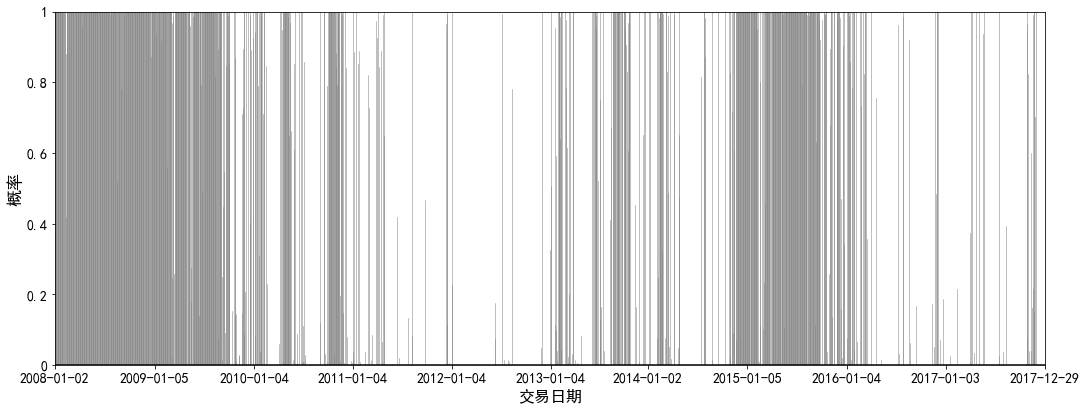

In [10]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig1, axes1 = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
fig1.tight_layout(pad=3, h_pad=4, w_pad=4)
xticks = [0, 246, 490, 732, 976, 1219, 1457, 1702, 1946, 2190, 2433]
markerline2, stemlines2, baseline2 = axes1.stem(thr_high_risk_prob, linefmt='-')
plt.setp(stemlines2, color='gray', linewidth=0.5)
plt.setp(markerline2, marker='')
plt.setp(baseline2, color='black')
axes1.set_xlim([0, len(thr_high_risk_prob)])
axes1.set_ylim([0, 1])
axes1.set_xticks(xticks)
axes1.set_xticklabels(trading_date[xticks], fontsize=14)
axes1.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1], fontsize=14)
axes1.set_xlabel(u'交易日期', fontsize=16)
axes1.set_ylabel(u'概率', fontsize=17)
fig1.savefig(OUTPUT_FIGURE_PATH + "/high risk probability.png", dpi=300)

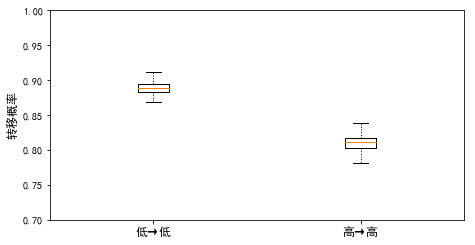

In [11]:
# transition probabilities
k2k_tran_prob = np.zeros([gibbs_sample_num, K])
for k in range(0, K):
    k2k_tran_prob[:, k] = thr_tran_matrix_samples[:, k, k]
    
fig2, axes2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
fig2.tight_layout(pad=3, h_pad=1, w_pad=1)
axes2.boxplot(k2k_tran_prob, 0, '', whiskerprops={'linestyle': ':'})
axes2.set_ylim(0.7,1)
axes2.set_xticks([1, 2])
axes2.set_xticklabels([u'低→低', u'高→高'], fontsize=12)
plt.ylabel(u'转移概率', fontsize=12)
fig2.savefig(OUTPUT_FIGURE_PATH + '/transition probabilities.png', dpi=300)

In [12]:
for i in range(0, K):
    print np.mean(k2k_tran_prob[:, i])

0.8893313899555324
0.8098521256813107


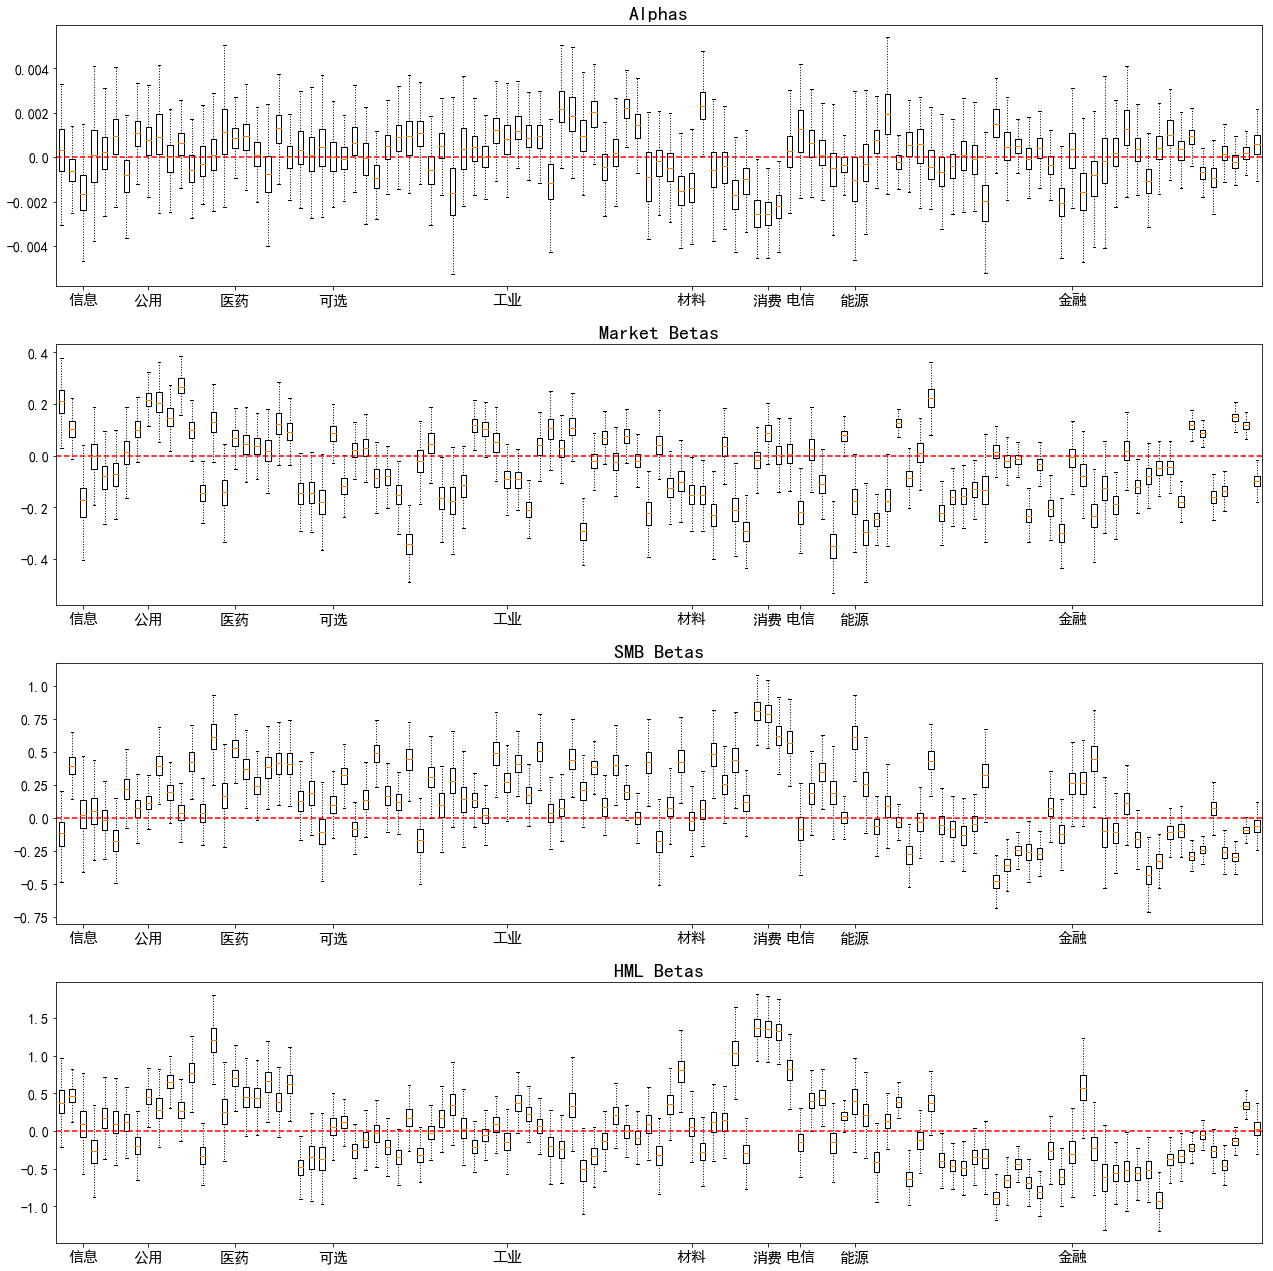

In [13]:
# beta coefficients distribution
from matplotlib.ticker import FormatStrFormatter
beta_title = {0: "Alphas", 1: "Market Betas", 2: "SMB Betas",
              3: "HML Betas", 4: 'RMW Betas', 5: 'CMA Betas'}
fig3, axes = plt.subplots(nrows=thr_factor_num, ncols=1, figsize=(18, 18))
fig3.tight_layout(pad=3, h_pad=4, w_pad=4)
thr_beta_diff = np.zeros([thr_factor_num, gibbs_sample_num, p])
for fn in range(0, thr_factor_num):
    nn = range(fn, fn + thr_n, thr_factor_num)
    thr_beta_diff[fn, :, :] = (thr_beta_samples[:, 0, nn] - thr_beta_samples[:, -1, nn]) * (-1)**thr_idtf
    thr_beta_diff[fn, :, :] = thr_beta_diff[fn][:, pos_list]     # sorted by Industry

    xticks_list = []
    for i in range(0, industry_num):
        xticks_list.append(pos_dict[industry_type[i]][len(pos_dict[industry_type[i]]) // 2])
    for i in range(0, len(xticks_list)):
        xticks_list[i] = pos_list.index(xticks_list[i])

    axes[fn].boxplot(thr_beta_diff[fn, :, :], 0, '', whiskerprops={'linestyle': ':'})
    axes[fn].axhline(0, color='r', linestyle="--")
    axes[fn].set_xticks(xticks_list)
    axes[fn].set_xticklabels([industry_type_dict[i] for i in industry_type], fontsize=15)
    axes[fn].set_yticklabels(axes[fn].get_yticks(), fontsize=14)
    axes[fn].set_title(beta_title[fn], fontsize=20)

axes[1].yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
fig3.savefig(OUTPUT_FIGURE_PATH + '/betas difference.png', dpi=fig3.dpi)

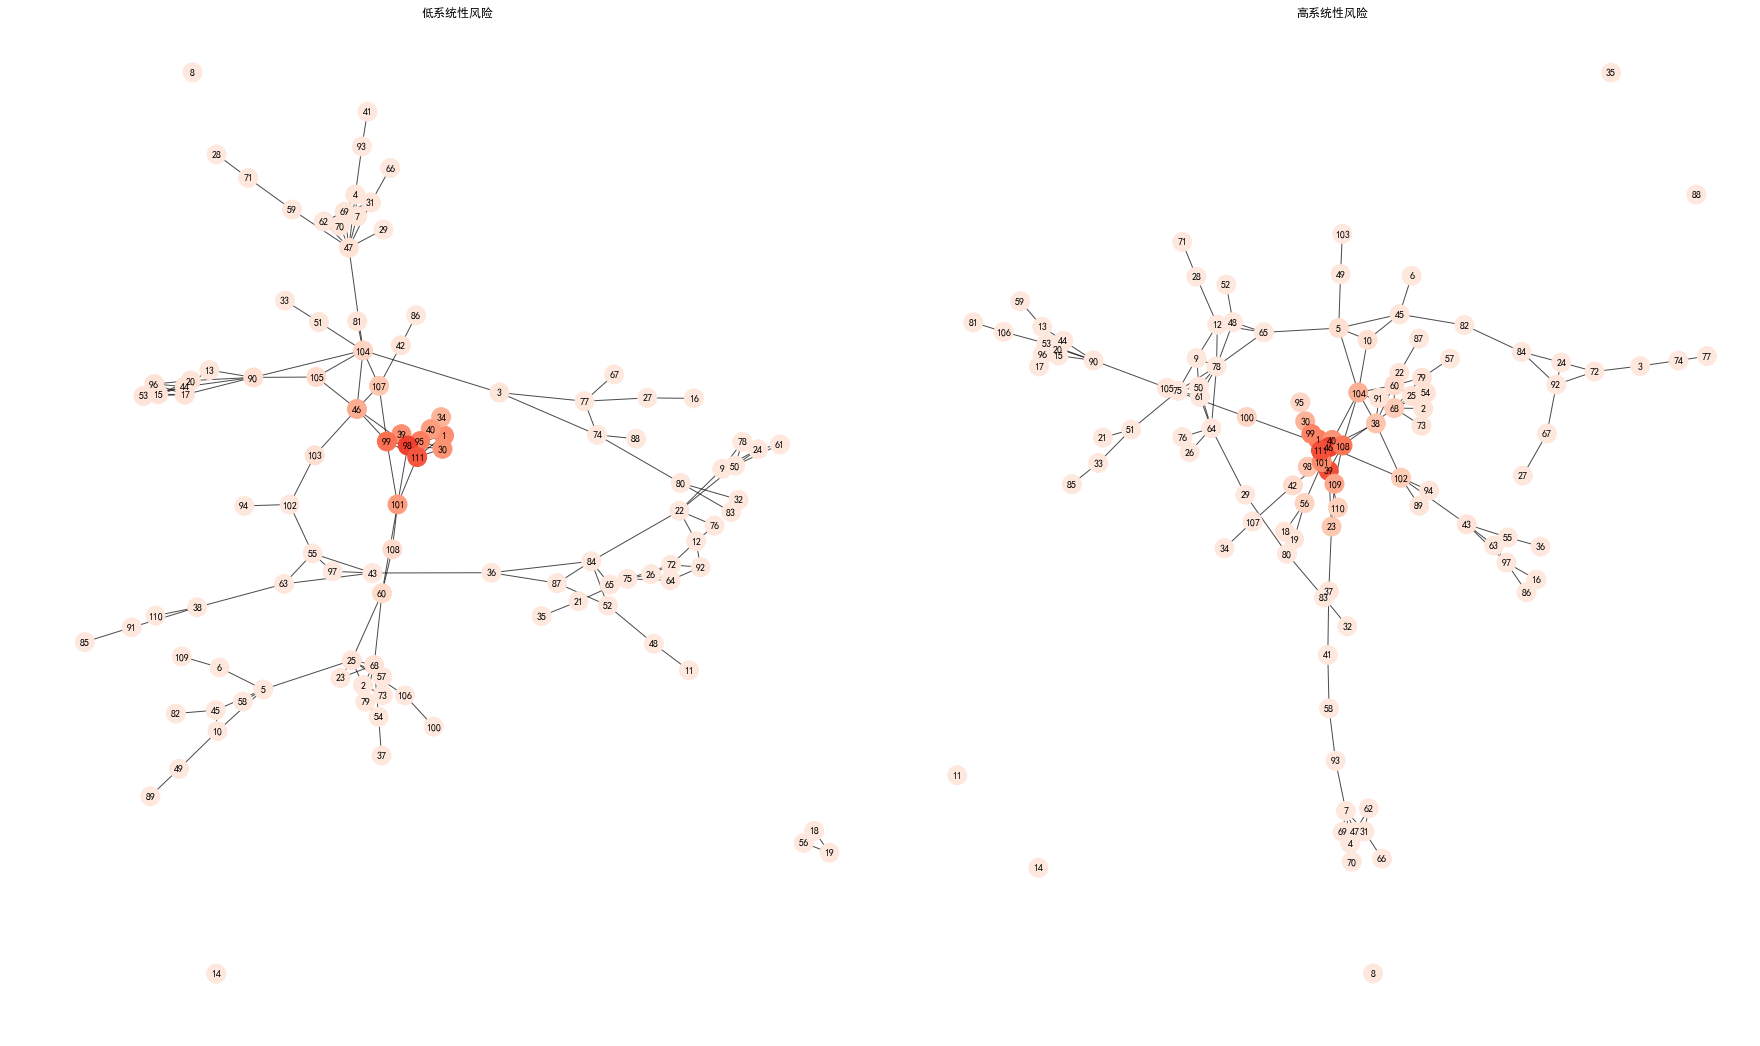

In [14]:
# Draw weighted networks example
fig4, axes4 = plt.subplots(nrows=1, ncols=2, figsize=(25, 15))
fig4.tight_layout(pad=3, h_pad=1, w_pad=1)
nodes_name = {i:i+1 for i in range(0, p)}
for k in range(0, K):
    G_example = thr_G_samples[-1][k]
    pos = nx.spring_layout(G_example)
    importance_dict = nx.eigenvector_centrality_numpy(G_example)
    nx.draw_networkx_edges(G_example, pos, alpha=0.7, ax=axes4[k])
    nx.draw_networkx_nodes(G_example, pos, nodelist=list(importance_dict.keys()),
                           node_size=360,
                           node_color=list(importance_dict.values()),
                           cmap=LinearSegmentedColormap.from_list('a', color_palette("Reds", n_colors=12)[:8]),
                           ax=axes4[k])
    nx.draw_networkx_labels(G_example, pos, labels=nodes_name, ax=axes4[k], font_color='black', font_size=10)
    axes4[k].set_title(thr_labels[k] + u"系统性风险")
    axes4[k].axis('off')
fig4.savefig(OUTPUT_FIGURE_PATH + "/networks.png")

In [15]:
# Degree Centrality, Standard Eigenvector Centrality and Weighted Eigenvector Centrality for individual stocks
thr_dgr_cen = np.zeros([gibbs_sample_num, K, p])
thr_std_eig_cen = np.zeros([gibbs_sample_num, K, p])
thr_weighted_eig_cen = np.zeros([gibbs_sample_num, K, p])

for i in range(0, gibbs_sample_num):
    for k in range(0, K):

        # in order to get weighted eigenvector centrality, weights are defined by the covariance terms.
        G_ik = thr_G_samples[i][k].copy()
        for node1, node2 in G_ik.edges:
            G_ik[node1][node2]['weight'] = thr_sigma_samples[i, k, node1, node2]

        dgr_dict = nx.degree_centrality(G_ik)
        std_eig_dict = nx.eigenvector_centrality_numpy(G_ik)
        weighted_eig_dict = nx.eigenvector_centrality_numpy(G_ik, weight='weight')
        thr_dgr_cen[i, k, :] = [dgr_dict[e] for e in sorted(dgr_dict.keys())]
        thr_std_eig_cen[i, k, :] = [std_eig_dict[e] for e in sorted(std_eig_dict.keys())]
        thr_weighted_eig_cen[i, k, :] = [weighted_eig_dict[e] for e in sorted(weighted_eig_dict.keys())]

thr_median_dgr_cen = np.median(thr_dgr_cen, axis=0)
thr_median_std_eig_cen = np.median(thr_std_eig_cen, axis=0)
thr_median_weighted_eig_cen = np.median(thr_weighted_eig_cen, axis=0)

std_eig_cen_dict = {u'高': thr_median_std_eig_cen[1], u'低': thr_median_std_eig_cen[0]}
weighted_eig_cen_dict = {u'高': thr_median_weighted_eig_cen[1], u'低': thr_median_weighted_eig_cen[0]}

In [16]:
np.savetxt('./output/median_std_eig_cen.txt', thr_median_std_eig_cen)
np.savetxt('./output/median_weighted_eig_cen.txt', thr_median_weighted_eig_cen)

In [17]:
cen = std_eig_cen_dict[u'低']
ranked_node = np.argsort(-cen)[: 20]
ranked_node

array([ 38,  97,  33,  98, 110, 100,  45,  94,  39,  29,   0, 106, 107,
       103,  24,  67,  59,   1, 108,  89], dtype=int64)

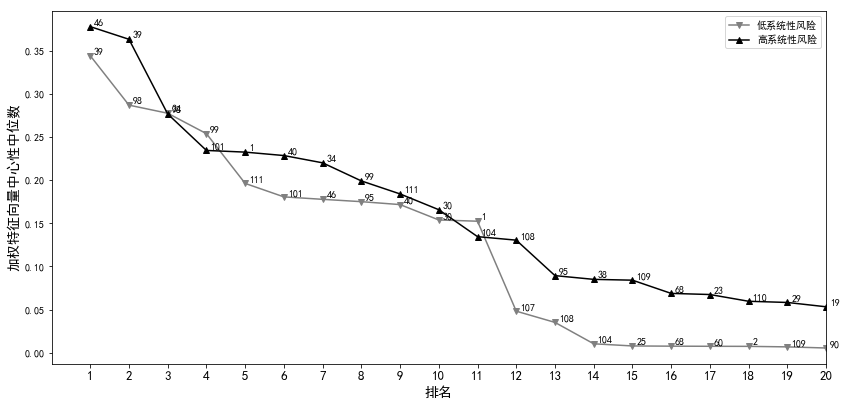

In [18]:
marker_dict = {u"高": '^', u"低": "v"}
line_colors = {u"高": "black", u"低": "gray"}
fig5, axes5 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig5.tight_layout(pad=3, h_pad=4, w_pad=3)
rank_num = 20
rank = range(1, p + 1)[: rank_num]
for k in [ u'低', u'高']:
    cen = std_eig_cen_dict[k]
    ranked_node = np.argsort(-cen)[: rank_num]
    axes5.plot(cen[ranked_node], color=line_colors[k], marker=marker_dict[k], label=k + u"系统性风险")
    for i in rank:
        axes5.text(i - 1 + 0.1, cen[ranked_node[i - 1]], str(ranked_node[i - 1]+1), va='bottom', 
                   ha='left', wrap=True)
axes5.set_xticks(range(0, p)[: rank_num])
axes5.set_xticklabels(rank, fontsize=13)
axes5.set_xlim([-1, np.min([p, rank_num]) - 1])
axes5.legend()
axes5.set_xlabel(u'排名', fontsize=14)
axes5.set_ylabel(u'加权特征向量中心性中位数', fontsize=14)
fig5.savefig(OUTPUT_FIGURE_PATH + "/std Eigenvector Centrality Rank.png")

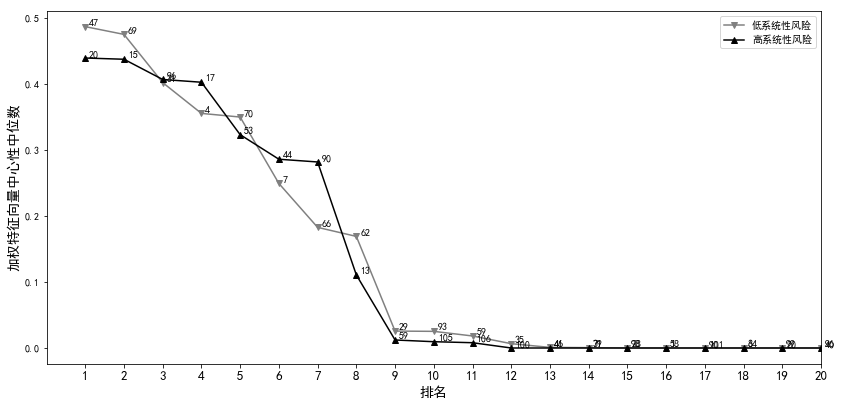

In [19]:
fig5, axes5 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
fig5.tight_layout(pad=3, h_pad=4, w_pad=3)
rank_num = 20
rank = range(1, p + 1)[: rank_num]
for k in [u'低', u'高']:
    cen = weighted_eig_cen_dict[k]
    ranked_node = np.argsort(-cen)[: rank_num]
    axes5.plot(cen[ranked_node], color=line_colors[k], marker=marker_dict[k], label=k + u"系统性风险")
    for i in rank:
        axes5.text(i - 1 + 0.1, cen[ranked_node[i - 1]], str(ranked_node[i - 1]+1), va='bottom', 
                   ha='left', wrap=True)
axes5.set_xticks(range(0, p)[: rank_num])
axes5.set_xticklabels(rank, fontsize=13)
axes5.set_xlim([-1, np.min([p, rank_num]) - 1])
axes5.legend()
axes5.set_xlabel(u'排名', fontsize=14)
axes5.set_ylabel(u'加权特征向量中心性中位数', fontsize=14)
fig5.savefig(OUTPUT_FIGURE_PATH + "/weighted Eigenvector Centrality Rank.png")

In [20]:
# Degree Centrality, Standard Eigenvector Centrality and Weighted Eigenvector Centrality for industries
if industry_num > 1:
    thr_ind_dgr_cen = np.zeros([gibbs_sample_num, K, industry_num])
    thr_ind_std_eig_cen = np.zeros([gibbs_sample_num, K, industry_num])
    thr_ind_weighted_eig_cen = np.zeros([gibbs_sample_num, K, industry_num])
    
    for i in range(0, industry_num):
        pos = pos_dict[industry_type[i]]
        thr_ind_dgr_cen[:, :, i] = np.mean(thr_dgr_cen[:, :, pos], axis=2)
        thr_ind_std_eig_cen[:, :, i] = np.mean(thr_std_eig_cen[:, :, pos], axis=2)
        thr_ind_weighted_eig_cen[:, :, i] = np.mean(thr_weighted_eig_cen[:, :, pos], axis=2)
    
    thr_median_ind_dgr_cen = np.median(thr_ind_dgr_cen, axis=0)
    thr_median_ind_std_eig_cen = np.median(thr_ind_std_eig_cen, axis=0)
    thr_median_ind_weighted_eig_cen = np.median(thr_ind_weighted_eig_cen, axis=0)
    
    ind_cen_dict = {'Weighted Eigenvector': thr_median_ind_weighted_eig_cen,
                    'Standard Eigenvector': thr_median_ind_std_eig_cen,}

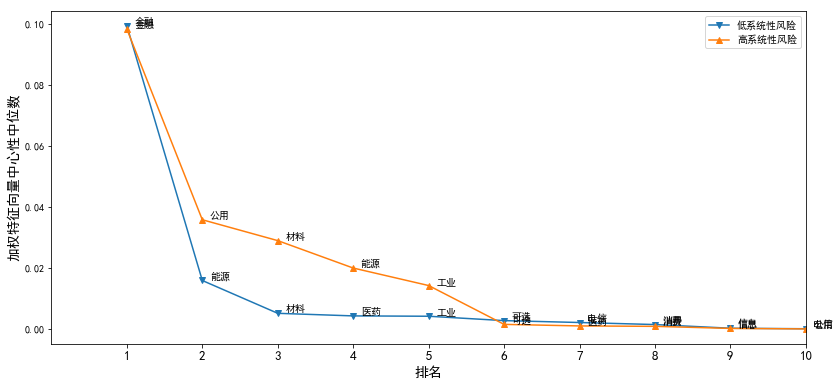

In [21]:
ind_labels = {0: u'低', 1: u'高'}
if industry_num > 1:
    fig6, axes6 = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    fig6.tight_layout(pad=4, h_pad=5, w_pad=5)
    ind_rank = range(1, industry_num + 1)
    for k in range(0, K):
        cen = ind_cen_dict['Standard Eigenvector'][k]
        ranked_node = np.argsort(-cen)
        axes6.plot(cen[ranked_node], marker=marker_dict[ind_labels[k]], label=ind_labels[k] +u'系统性风险' )
        for i in ind_rank:
            axes6.text(i-1 + 0.1, cen[ranked_node[i-1]], industry_type_dict[industry_type[ranked_node[i-1]]], 
                       va='bottom', ha='left', wrap=True)
    axes6.set_xticks(range(0, industry_num))
    axes6.set_xticklabels(ind_rank, fontsize=13)
    axes6.set_xlim([-1, industry_num - 1])
    axes6.legend()
    axes6.set_xlabel(u'排名', fontsize=14)
    axes6.set_ylabel(u'加权特征向量中心性中位数', fontsize=14)
    fig6.savefig(OUTPUT_FIGURE_PATH + "/Industries' Centrality Rank.png")

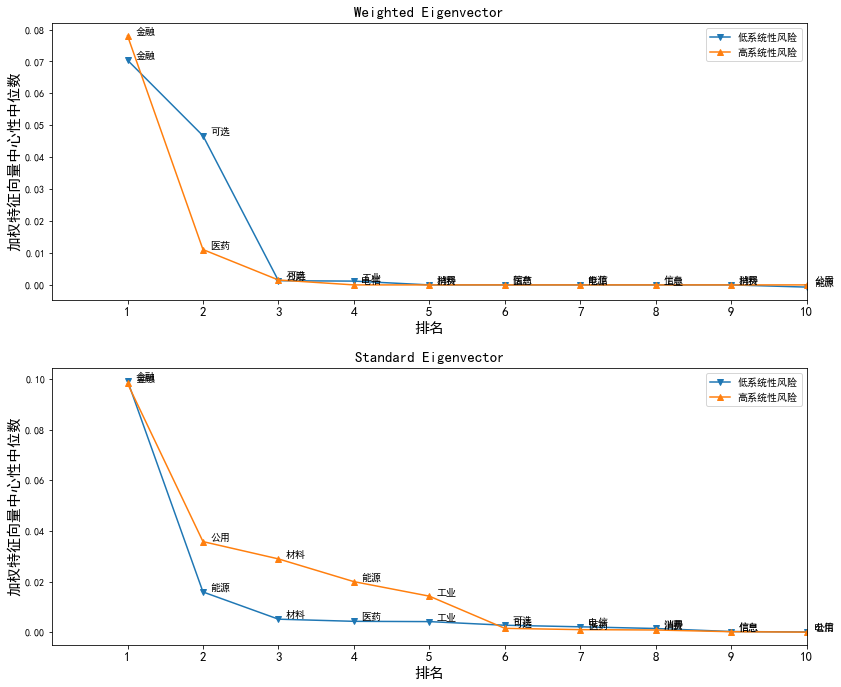

In [22]:
ind_keys = ['Weighted Eigenvector', 'Standard Eigenvector']
ind_labels = {0: u'低', 1: u'高'}
if industry_num > 1:
    fig6, axes6 = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))
    fig6.tight_layout(pad=4, h_pad=5, w_pad=5)
    ind_rank = range(1, industry_num + 1)
    for m in range(0, len(ind_keys)):
        for k in range(0, K):
            cen = ind_cen_dict[ind_keys[m]][k]
            ranked_node = np.argsort(-cen)
            axes6[m].plot(cen[ranked_node], marker=marker_dict[ind_labels[k]], label=ind_labels[k] +u'系统性风险' )
            for i in ind_rank:
                axes6[m].text(i-1 + 0.1, cen[ranked_node[i-1]], industry_type_dict[industry_type[ranked_node[i-1]]],
                              va='bottom', ha='left', wrap=True)
        axes6[m].set_xticks(range(0, industry_num))
        axes6[m].set_xticklabels(ind_rank, fontsize=13)
        axes6[m].set_xlim([-1, industry_num - 1])
        axes6[m].legend()
        axes6[m].set_xlabel(u'排名', fontsize=15)
        axes6[m].set_ylabel(u'加权特征向量中心性中位数', fontsize=15)
        axes6[m].set_title(ind_keys[m], fontsize=15)
    fig6.savefig(OUTPUT_FIGURE_PATH + "/Industries' Centrality Rank(2).png")

In [23]:
# 探讨系统重要性与规模的关系
thr_y_high = std_eig_cen_dict[u'高']
thr_y_low = std_eig_cen_dict[u'低']
mkt_value = np.loadtxt('./intermediate/mkt_value/all.txt')
ln_mkt_value = np.log(mkt_value)
mean_mkt_value = np.mean(ln_mkt_value, axis=0)

In [24]:
reg1 = sm.OLS(thr_y_high, sm.add_constant(mean_mkt_value))
res1 = reg1.fit()
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     30.25
Date:                Fri, 25 Jan 2019   Prob (F-statistic):           2.54e-07
Time:                        17:12:42   Log-Likelihood:                 143.56
No. Observations:                 111   AIC:                            -283.1
Df Residuals:                     109   BIC:                            -277.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5456      0.105     -5.176      0.0

In [25]:
reg2 = sm.OLS(thr_y_low, sm.add_constant(mean_mkt_value))
res2 = reg2.fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     18.00
Date:                Fri, 25 Jan 2019   Prob (F-statistic):           4.66e-05
Time:                        17:12:46   Log-Likelihood:                 151.24
No. Observations:                 111   AIC:                            -298.5
Df Residuals:                     109   BIC:                            -293.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3932      0.098     -3.997      0.0